# Marketing Campaign Clustering Analysis

This notebook performs clustering analysis on a marketing campaign dataset using the Gaussian Mixture Model (GMM) algorithm. The goal is to identify customer segments based on their behavior and demographic information.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans as SKLearnKMeans
import warnings
import sys
from sklearn.metrics import silhouette_score
from models.KMeans import KMeans  # Importing the custom KMeans class
from models.HierarchicalClustering import myAgglomerativeHierarchicalClustering
from models.dbscan import run_dbscan
from models.GMM import GMM


if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Load Data

In [2]:
data = pd.read_csv("..\data\marketing_campaign.csv", sep="\t")

## Data Cleaning

In [3]:
data = data.dropna()

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")
dates = data["Dt_Customer"].dt.date
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))

data["Customer_For"] = (max(dates) - data["Dt_Customer"].dt.date).apply(lambda x: x.days)
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())


The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30
Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


## Feature Engineering

In [4]:
data["Age"] = 2021 - data["Year_Birth"]
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]
data["Living_With"] = data["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})
data["Children"] = data["Kidhome"] + data["Teenhome"]
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)
data["Education"] = data["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
data = data.rename(columns={"MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts": "Meat", "MntFishProducts": "Fish", "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"})


## Drop Redundant Features

In [5]:
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)


## Plot Selected Features

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

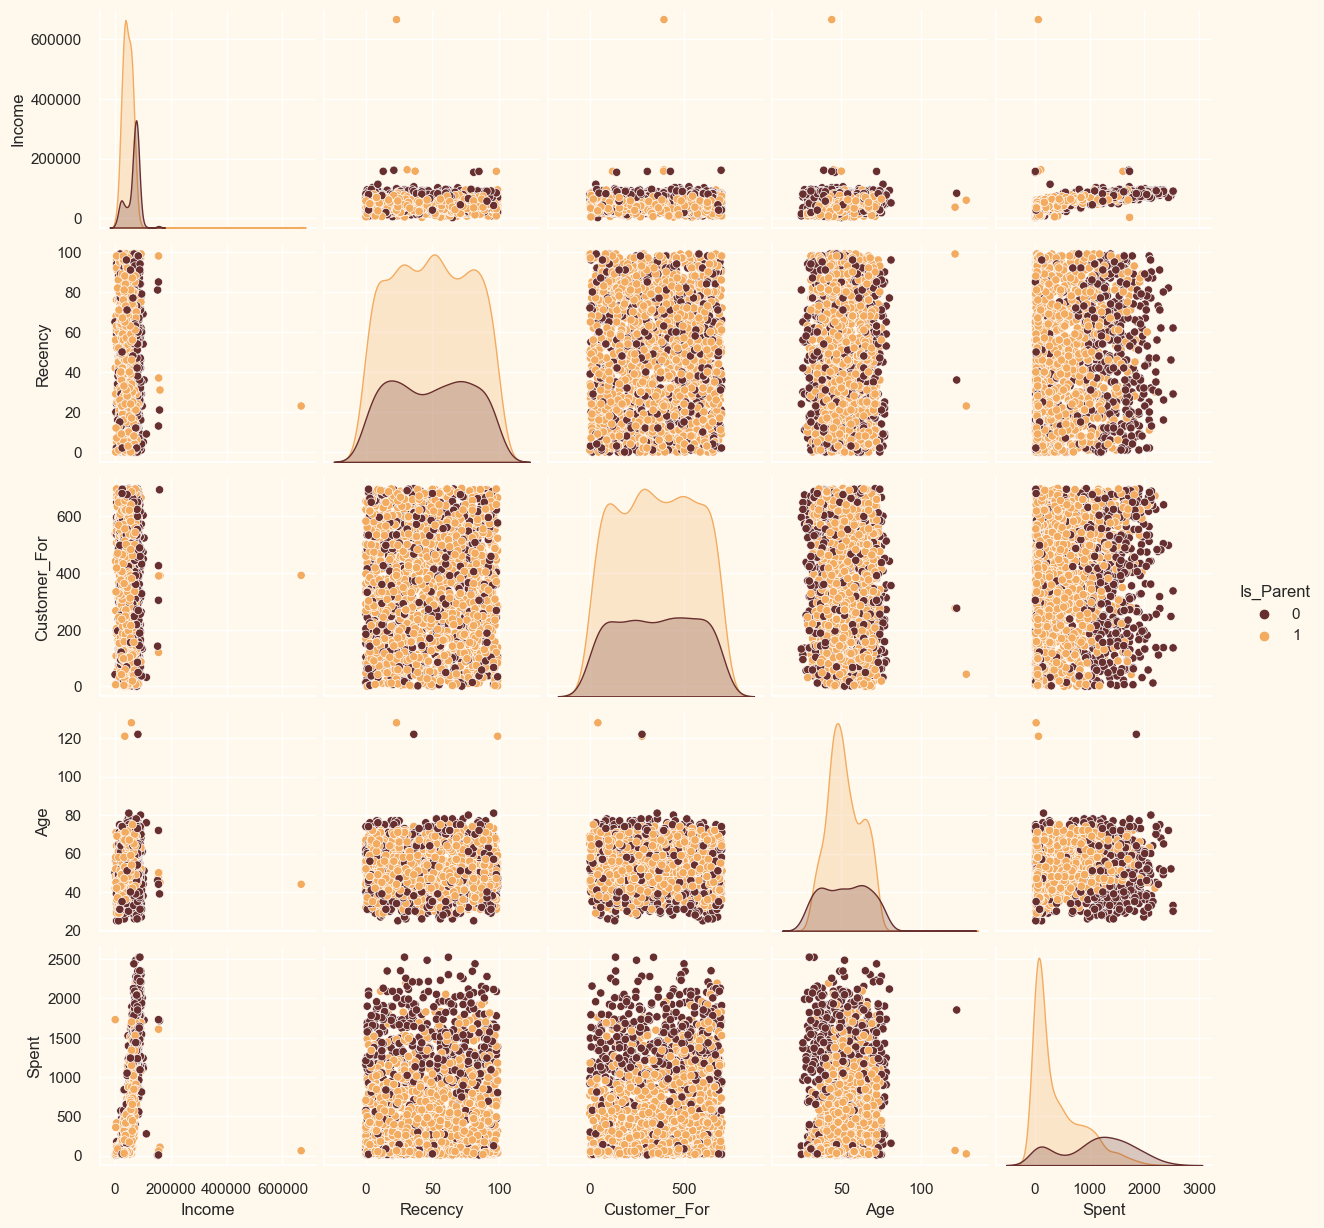

In [6]:
sns.set(rc={"axes.facecolor": "#FFF9ED", "figure.facecolor": "#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue="Is_Parent", palette=(["#682F2F", "#F3AB60"]))
plt.show()


## Remove Outliers

In [7]:
data = data[(data["Age"] < 90)]
data = data[(data["Income"] < 600000)]
print("The total number of data-points after removing the outliers are:", len(data))


The total number of data-points after removing the outliers are: 2212


## Correlation Matrix

<AxesSubplot:>

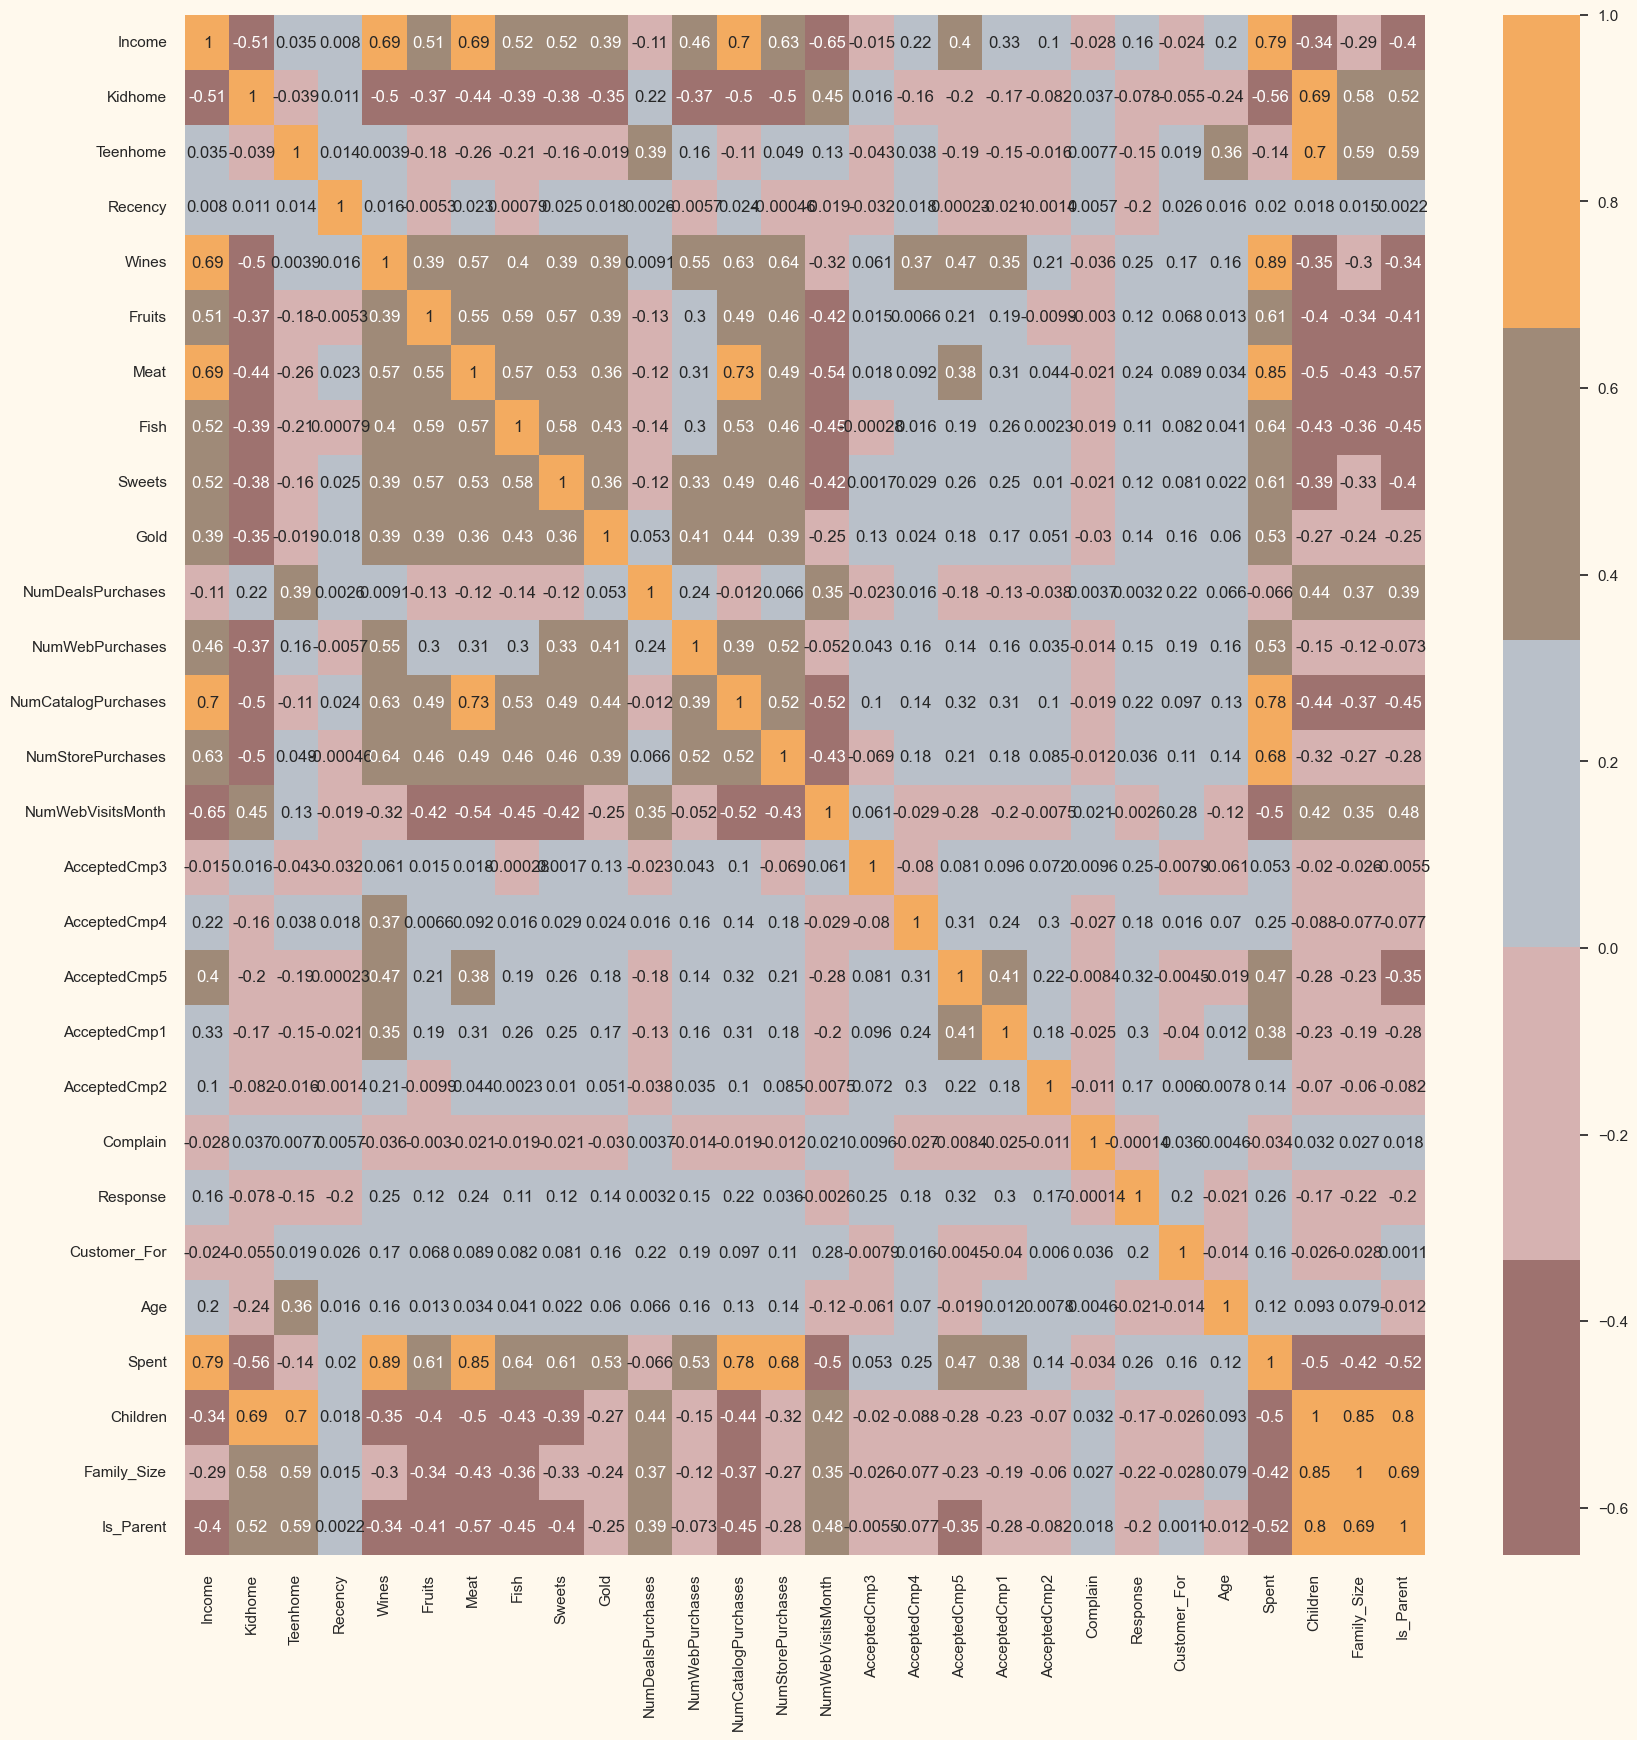

In [8]:
numeric_data = data.select_dtypes(include=[np.number])
corrmat = numeric_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)


## Data Preprocessing

In [9]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

LE = LabelEncoder()
for i in object_cols:
    data[i] = data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

ds = data.copy()
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns)
print("All features are now scaled")


Categorical variables in the dataset: ['Education', 'Living_With']
All features are now numerical
All features are now scaled


## Dimensionality Reduction

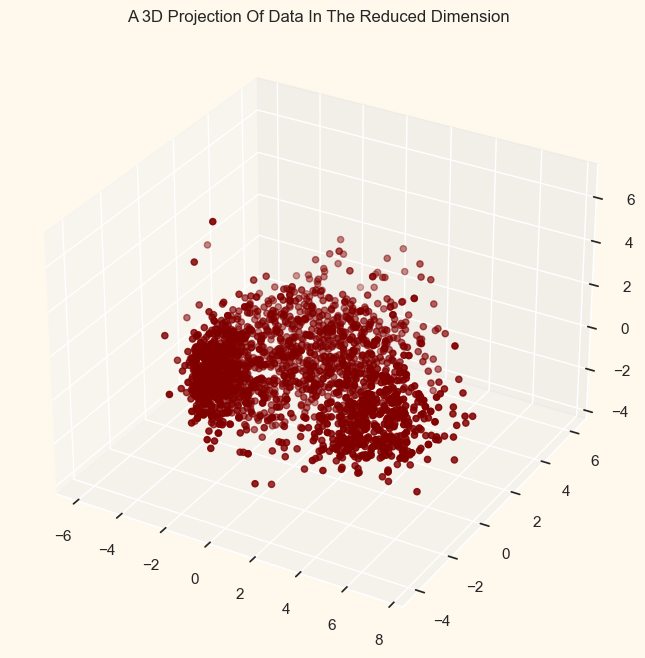

In [10]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1", "col2", "col3"]))
PCA_ds.describe().T

x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c="maroon", marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()


Elbow Method to determine the number of clusters to be formed:


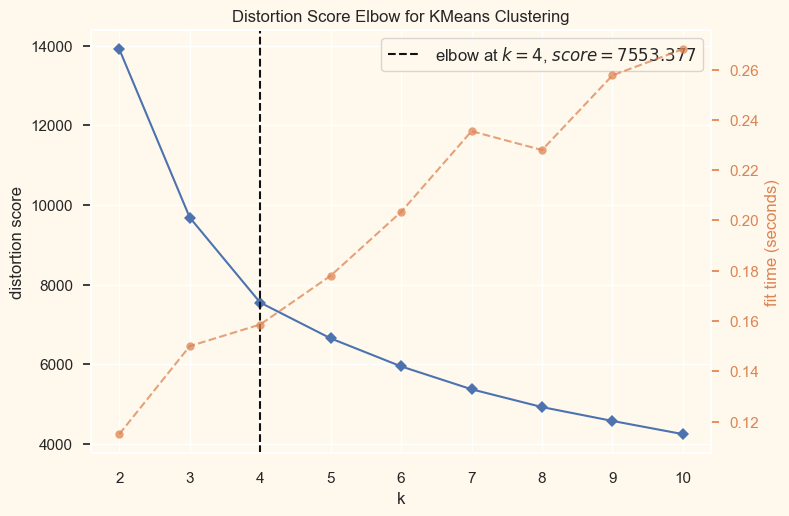

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(SKLearnKMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

## Clustering

### KMeans

Convergence reached at iteration 7
Convergence reached at iteration 9
K=2, Silhouette Score: 0.4446
Convergence reached at iteration 26
Convergence reached at iteration 27
K=3, Silhouette Score: 0.4108
Convergence reached at iteration 25
Convergence reached at iteration 13
K=4, Silhouette Score: 0.3732
Best K: 2, Best Silhouette Score: 0.4446


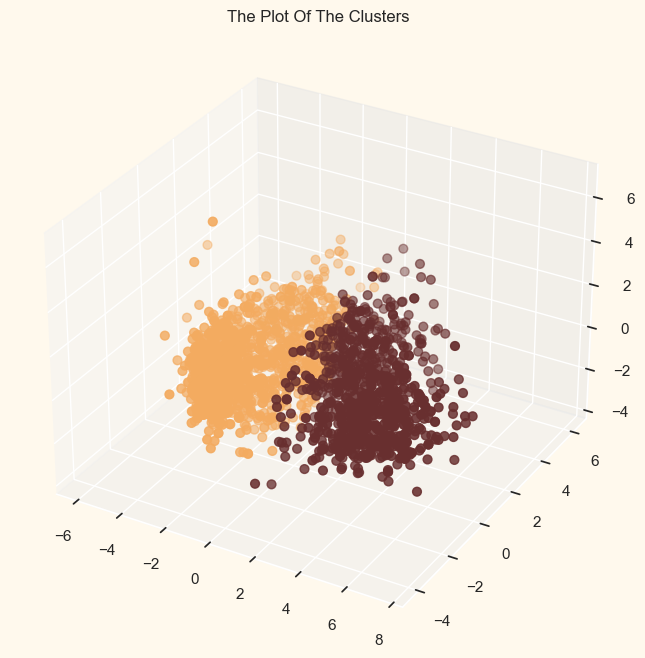

In [12]:
best_silhouette = -1
best_k = 0
best_kmeans = None
best_cluster_assignments = None
KMeans_PCA_ds = PCA_ds

for k in range(2, 5):
    kmeans = KMeans(X=KMeans_PCA_ds, n_clusters=k)
    kmeans.fit(KMeans_PCA_ds)
    cluster_labels = kmeans.predict(KMeans_PCA_ds)
    silhouette = silhouette_score(KMeans_PCA_ds, cluster_labels)
    print(f"K={k}, Silhouette Score: {silhouette:.4f}")
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k
        best_kmeans = kmeans
        best_cluster_assignments = cluster_labels

print(f"Best K: {best_k}, Best Silhouette Score: {best_silhouette:.4f}")

# 绘制KMeans聚类结果
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_cluster_assignments, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

### HierarchicalClustering

In [ ]:
best_silhouette = -1
best_k = 0
best_ahc = None
best_cluster_assignments = None
ahc_PCA_ds = PCA_ds

for k in range(2, 5):
    ahc = myAgglomerativeHierarchicalClustering(data=ahc_PCA_ds.values, K=k, M='euclidean')
    cluster_labels = ahc.run_algorithm()
    silhouette = silhouette_score(ahc_PCA_ds, cluster_labels)
    print(f"K={k}, Silhouette Score: {silhouette:.4f}")
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k
        best_ahc = ahc
        best_cluster_assignments = cluster_labels
print(f"Best K: {best_k}, Best Silhouette Score: {best_silhouette:.4f}")

# 将最佳的聚类结果添加到数据集中
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_cluster_assignments, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

### DBscan

eps=0.1, min_samples=2, Silhouette Score: 0.8874
eps=0.1, min_samples=3, Silhouette Score: 0.7823
eps=0.1, min_samples=4, Silhouette Score: 0.8070
eps=0.2, min_samples=2, Silhouette Score: 0.5084
eps=0.2, min_samples=3, Silhouette Score: 0.3959
eps=0.2, min_samples=4, Silhouette Score: 0.3735
eps=0.30000000000000004, min_samples=2, Silhouette Score: 0.1153
eps=0.30000000000000004, min_samples=3, Silhouette Score: 0.0732
eps=0.30000000000000004, min_samples=4, Silhouette Score: 0.2198
eps=0.4, min_samples=2, Silhouette Score: -0.2657
eps=0.4, min_samples=3, Silhouette Score: -0.2400
eps=0.4, min_samples=4, Silhouette Score: -0.1336
eps=0.5, min_samples=2, Silhouette Score: -0.3544
eps=0.5, min_samples=3, Silhouette Score: -0.2724
eps=0.5, min_samples=4, Silhouette Score: -0.2649
eps=0.6, min_samples=2, Silhouette Score: -0.2642
eps=0.6, min_samples=3, Silhouette Score: -0.1715
eps=0.6, min_samples=4, Silhouette Score: -0.0539
eps=0.7000000000000001, min_samples=2, Silhouette Score: -0.4

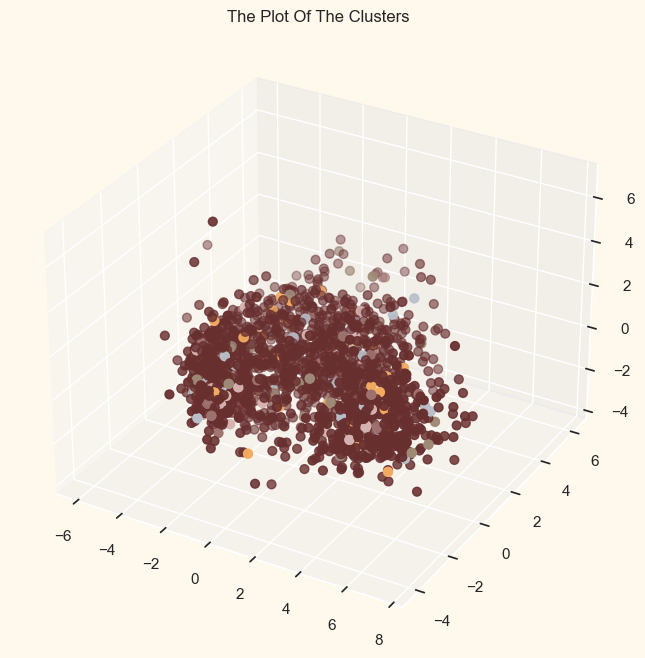

In [15]:
best_silhouette = -1
best_eps = 0
best_min_samples = 0
best_dbscan_labels = None
DBscan_PCA_ds = PCA_ds

# 定义参数范围
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(2, 5)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_labels = run_dbscan(DBscan_PCA_ds.values, eps=eps, min_samples=min_samples)
        unique_labels = np.unique(dbscan_labels[dbscan_labels!= -1])  # 获取非噪声点的不同标签
        if len(unique_labels) < 2:  # 如果非噪声点的聚类标签少于2个，跳过当前参数组合
            continue
        non_noise_mask = dbscan_labels!= -1
        silhouette = silhouette_score(DBscan_PCA_ds[non_noise_mask], dbscan_labels[non_noise_mask])
        print(f"eps={eps}, min_samples={min_samples}, Silhouette Score: {silhouette:.4f}")
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps
            best_min_samples = min_samples
            best_dbscan_labels = dbscan_labels

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette:.4f}")

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_dbscan_labels, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

### GMM

Data scaled.
Parameters initialized.
mu:
[[0.67735982 0.43138607 0.34765859]
 [0.29309356 0.38737487 0.35073058]]
cov:
[[[0.1 0.  0. ]
  [0.  0.1 0. ]
  [0.  0.  0.1]]

 [[0.1 0.  0. ]
  [0.  0.1 0. ]
  [0.  0.  0.1]]]
alpha:
[0.5 0.5]
-------------------- Result --------------------
mu:
[[0.56219695 0.46023565 0.3528846 ]
 [0.25394762 0.31426707 0.34401559]]
cov:
[[[ 0.03569696 -0.01401269 -0.00236103]
  [-0.01401269  0.02614969  0.00381909]
  [-0.00236103  0.00381909  0.0144029 ]]

 [[ 0.0036709  -0.00502793  0.00215878]
  [-0.00502793  0.01570036 -0.00703699]
  [ 0.00215878 -0.00703699  0.01354454]]]
alpha:
[0.62011488 0.37988512]
K=2, Silhouette Score: 0.3073
Data scaled.
Parameters initialized.
mu:
[[0.46927352 0.5931125  0.37281524]
 [0.27005535 0.32249303 0.34330859]
 [0.75146038 0.31501773 0.33072857]]
cov:
[[[0.1 0.  0. ]
  [0.  0.1 0. ]
  [0.  0.  0.1]]

 [[0.1 0.  0. ]
  [0.  0.1 0. ]
  [0.  0.  0.1]]

 [[0.1 0.  0. ]
  [0.  0.1 0. ]
  [0.  0.  0.1]]]
alpha:
[0.33333333 0.33

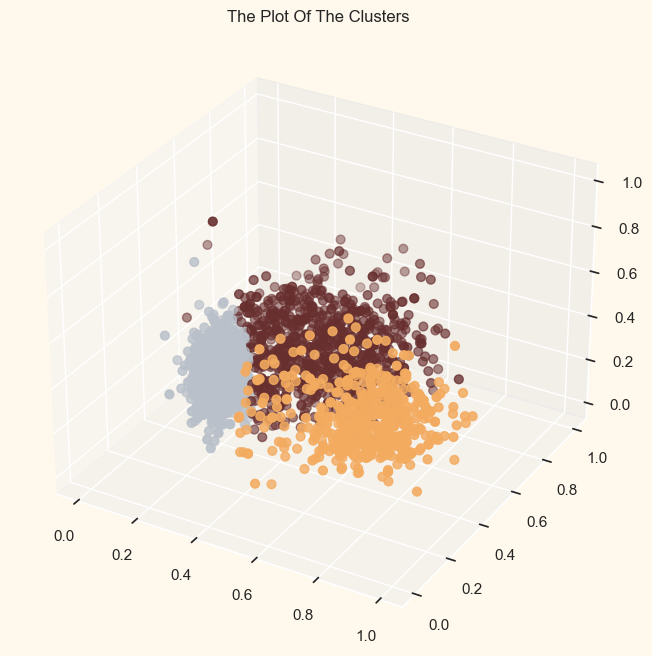

In [ ]:
best_silhouette = -1
best_k = 0
best_gmm = None
best_cluster_assignments = None
GMM_PCA_ds = PCA_ds
for k in range(2, 10):
    gmm = GMM(K=k, max_iter=100, tol=1e-6)
    mu, cov, alpha = gmm.fit(GMM_PCA_ds.values)
    gamma = gmm._get_expectation(GMM_PCA_ds.values, mu, cov, alpha)
    cluster_assignments = np.argmax(gamma, axis=1)
    silhouette = silhouette_score(GMM_PCA_ds, cluster_assignments)
    print(f"K={k}, Silhouette Score: {silhouette:.4f}")
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k
        best_gmm = gmm
        best_cluster_assignments = cluster_assignments

print(f"Best K: {best_k}, Best Silhouette Score: {best_silhouette:.4f}")

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_cluster_assignments, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()


### DEC

In [ ]:
"""
from models.dec import DEC

best_silhouette = -1
best_k = 0
best_dec = None
best_cluster_assignments = None
dec_PCA_ds = PCA_ds
for k in range(2, 10):
    dec = DEC(n_clusters=k)
    dec.build_autoencoder(dec_PCA_ds.shape[1])
    dec.train_autoencoder(dec_PCA_ds.values, epochs=100, batch_size=256)
    dec.clustering(dec_PCA_ds.values, batch_size=256, epochs=100)

    encoded_X = dec.encoder.predict(dec_PCA_ds.values)
    cluster_labels = np.argmax(dec._calculate_cluster_probabilities(dec_PCA_ds.values), axis=1)

    silhouette = silhouette_score(encoded_X, cluster_labels)
    print(f"K={k}, Silhouette Score: {silhouette:.4f}")
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k
        best_dec = dec
        best_cluster_assignments = cluster_labels

print(f"Best K: {best_k}, Best Silhouette Score: {best_silhouette:.4f}")

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_cluster_assignments, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()
"""

ImportError: cannot import name 'OrderedDict' from 'typing' (g:\Anaconda\envs\lab3\lib\typing.py)

### Spectral Clustering

K=2, Silhouette Score: 0.3948
K=3, Silhouette Score: 0.2617
K=4, Silhouette Score: 0.3626
Best K: 2, Best Silhouette Score: 0.3948


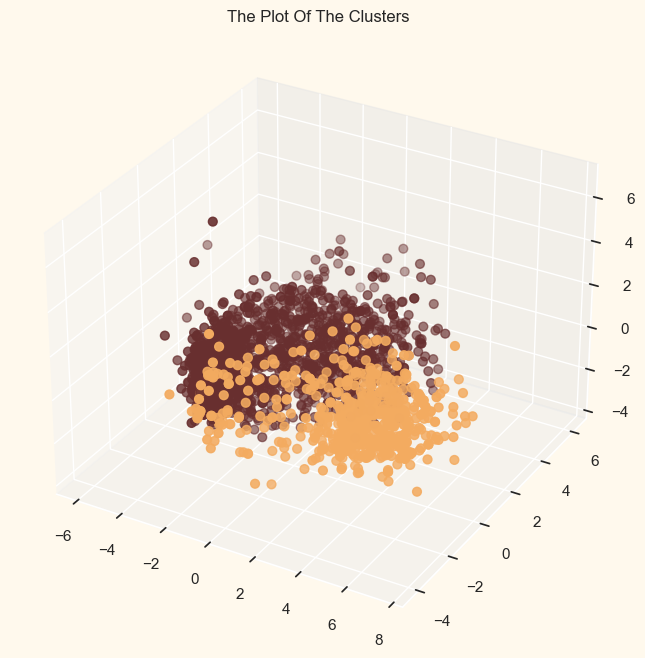

In [22]:
from models.SpectralClustering import mySpectralClustering

best_silhouette = -1
best_k = 0
best_spectral = None
best_cluster_assignments = None
spectral_PCA_ds = PCA_ds

# 定义参数范围
k_values = range(2, 5)
KNN_k = 5  # 假设KNN参数为5

for k in k_values:
    spectral = mySpectralClustering(n_clusters=k, KNN_k=KNN_k)
    cluster_labels = spectral.fit(spectral_PCA_ds.values)

    # 计算轮廓系数
    silhouette = silhouette_score(spectral_PCA_ds, cluster_labels)
    print(f"K={k}, Silhouette Score: {silhouette:.4f}")
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k
        best_spectral = spectral
        best_cluster_assignments = cluster_labels

print(f"Best K: {best_k}, Best Silhouette Score: {best_silhouette:.4f}")

# 将最佳的聚类结果添加到数据集中

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_cluster_assignments, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

### Contrastive Clustering

K=4, Silhouette Score: 0.0175
Best K: 4, Best Silhouette Score: 0.0175


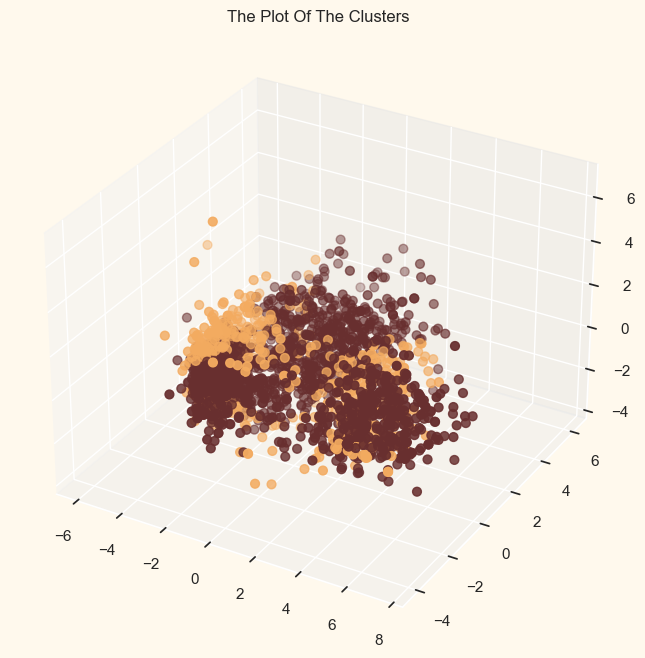

In [20]:
from models.ContrastiveCluster import ContrastiveCluster  # Importing the custom ContrastiveCluster class
from torch import optim
from torch import torch
best_silhouette = -1
best_k = 0
best_model = None
best_cluster_assignments = None
CC_PCA_ds = PCA_ds
# 定义参数范围
k_values = range(4, 5)

for k in k_values:
    model = ContrastiveCluster(input_dim=CC_PCA_ds.shape[1], n_clusters=k)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    model.train()
    for epoch in range(100):  # 假设训练100个epoch
        optimizer.zero_grad()
        loss = model.loss(torch.tensor(CC_PCA_ds.values, dtype=torch.float32))
        loss.backward()
        optimizer.step()

    # 预测聚类标签
    model.eval()
    with torch.no_grad():
        cluster_labels = model.predict(torch.tensor(CC_PCA_ds.values, dtype=torch.float32)).numpy()

    # 计算轮廓系数
    silhouette = silhouette_score(CC_PCA_ds, cluster_labels)
    print(f"K={k}, Silhouette Score: {silhouette:.4f}")
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k
        best_model = model
        best_cluster_assignments = cluster_labels

print(f"Best K: {best_k}, Best Silhouette Score: {best_silhouette:.4f}")

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=best_cluster_assignments, marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()